In [33]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point, Polygon, MultiPoint
from sklearn.cluster import KMeans
import numpy as np

Import Data and Organize Columns, and remove bad data

In [110]:
gdf = gpd.read_file("../data/SANGIS/BUSINESS_SITES/BUSINESS_SITES.shp")

In [112]:
gdf = gdf[gdf['POINT_X']!=0]
gdf['x'] = gdf['geometry'].x
gdf['y'] = gdf['geometry'].y

/Users/michaelsmith/opt/anaconda3/envs/dt_employment_center/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/michaelsmith/opt/anaconda3/envs/dt_employment_center/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Generate Hexbins
(note - gridsize was manually calculated based on width of SD County to generate roughly 1/4 mile radius hexbins:
SD County is roughly 86 miles east to west, and the grid size takes the quantity of hexbins by width
)

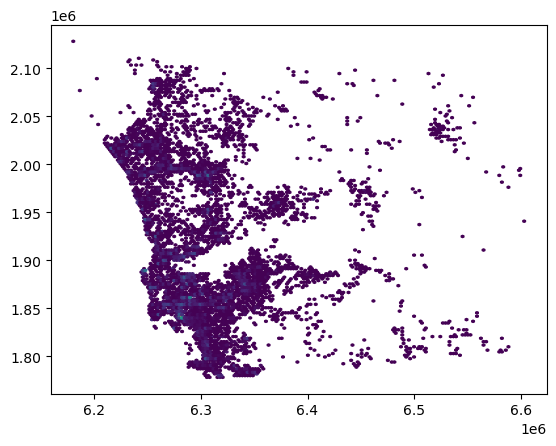

In [122]:
hexes = matplotlib.pyplot.hexbin( x= gdf['x'], y=gdf['y'],mincnt=1,gridsize=86*2)

In [123]:
hexbins = gpd.points_from_xy(x=[i[0] for i in hexes.get_offsets()],y=[i[1] for i in hexes.get_offsets()])[1:]

Merge the data with the newly generated hexbins

In [125]:
left_merge = gpd.GeoDataFrame(hexbins, geometry=0)

In [126]:
full_merge = gpd.sjoin_nearest(left_merge,gdf,how='right')

/var/folders/9y/511s41v52w36jc3xv1hv8l2m0000gn/T/ipykernel_15847/318931066.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:2230

  full_merge = gpd.sjoin_nearest(left_merge,gdf,how='right')


Count the # of datapoints in each hexbin

In [127]:
index_and_counts = full_merge.groupby('index_left').count().sort_values(by='x').reset_index()[['index_left','APN',]]

In [128]:
def get_x(index):
    return hexbins[index].x
def get_y(index):
    return hexbins[index].y

In [129]:
index_and_counts['x'] = index_and_counts['index_left'].apply(get_x)
index_and_counts['y'] = index_and_counts['index_left'].apply(get_y)
index_and_counts['geometry'] = gpd.points_from_xy(index_and_counts['x'], index_and_counts['y'])

In [130]:
df = gpd.GeoDataFrame(index_and_counts)

<Axes: >

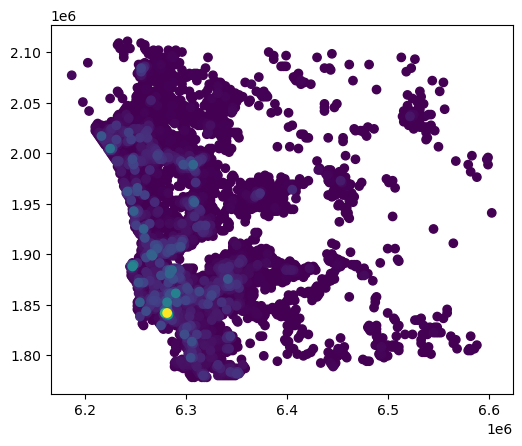

In [131]:
df.plot(column='APN')

Clustering techniques - use maxima as cluster centers and run kmeans for distance

<Axes: >

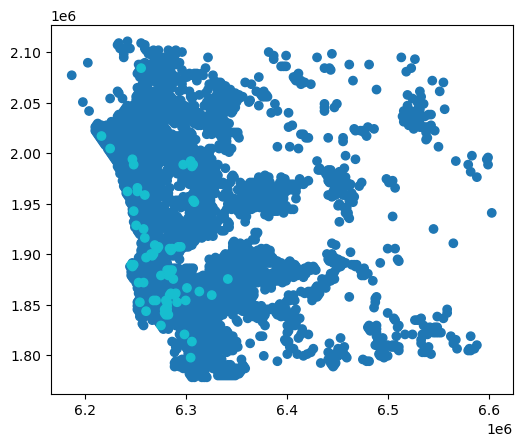

In [135]:
# idea 1 - could we use 70 biggest maxima as centers?
df['is_center'] = df['APN']>=df['APN'].sort_values(ascending=False).reset_index(drop=True)[70]
df.plot(column='is_center')

In [136]:
# clustering based off local maxima centers using kmeans
cluster_centers = df[df['is_center']==True][['x', 'y']].values
other_points = df[['x', 'y']].values
k = len(cluster_centers)
kmeans = KMeans(n_clusters=k, init=cluster_centers, n_init=1)
kmeans.fit(other_points)
df['cluster'] = kmeans.labels_

<Axes: >

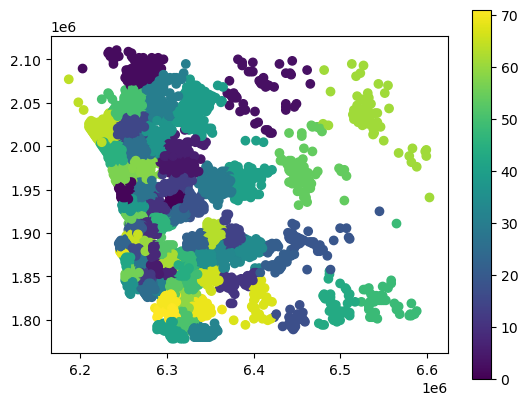

In [137]:
df.plot(column='cluster', legend=True)

What is the difference from just clustering on distance

<Axes: >

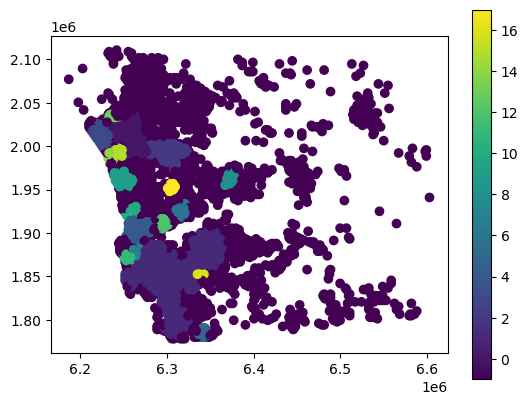

In [145]:
# other idea - what does python have available? 
# basic dbscan clustering on distance
scaler = StandardScaler()
df['scaled_weight'] = scaler.fit_transform(df[['APN']])
features = df[['x', 'y','APN']]
dbscan = DBSCAN(eps=6000, min_samples=20)
df['cluster_label'] = dbscan.fit_predict(features)
df.plot(column='cluster_label', legend=True)

<Axes: >

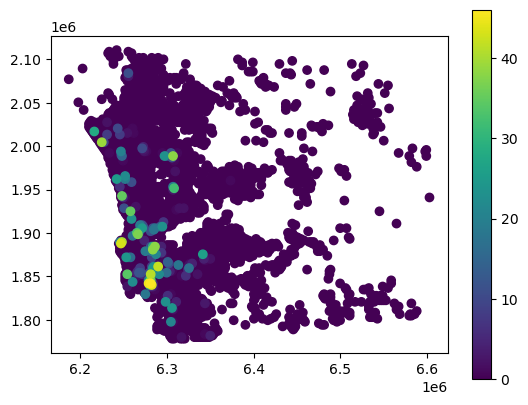

In [139]:
# other idea - db scan but for just the counts to find local maxima?
scaler = StandardScaler()
df['scaled_weight'] = scaler.fit_transform(df[['APN']])
features = df[['APN']]
dbscan = DBSCAN(eps=1, min_samples=1)
df['cluster_label'] = dbscan.fit_predict(features)
df.plot(column='cluster_label', legend=True)

Generate Polygons from local maxima approach

<Axes: >

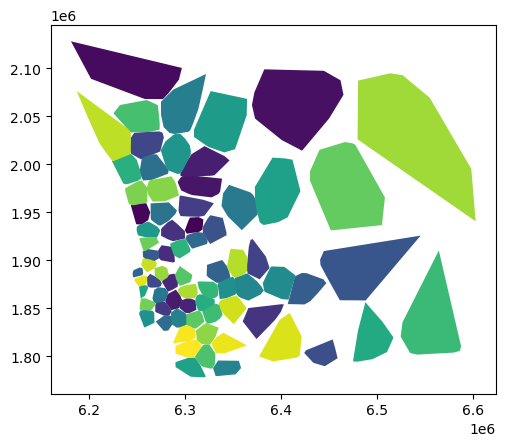

In [146]:
poly_df = full_merge.merge(df[['index_left','cluster']],how='left')

geometry = poly_df['geometry'].apply(Point)
gpdf = gpd.GeoDataFrame(poly_df, geometry=geometry)

grouped = gpdf.groupby('cluster')

polygons = []
for cluster, group in grouped:
    polygon = group['geometry'].unary_union.convex_hull
    polygons.append({'cluster': cluster, 'geometry': polygon})

polygons_gdf = gpd.GeoDataFrame(polygons)

polygons_gdf.plot(column='cluster')
